In [2]:

# Install esm and other dependencies
! pip install esm
! pip install matplotlib
! pip install seaborn


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#Set up Forge client for ESM C
from getpass import getpass
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token='1tZMaSRNt8PiudZrSQvq1p'
)

c:\Users\johan\OneDrive\Dokumente\GitHub\group04-team04\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

In [6]:
ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

adk_path = "../data/ab_ag_annotated_with_CDR_strings.tsv"

df = pd.read_csv(adk_path, sep="\t")
df = df[["CDR_H1_string", "CDR_H2_string", "CDR_L1_string", "CDR_L2_string", "CDR_L3_string","antigen_name"]]


In [8]:
outputs = batch_embed(model, df["CDR_H1_string"].tolist())

c:\Users\johan\OneDrive\Dokumente\GitHub\group04-team04\.conda\Lib\site-packages\esm\utils\misc.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


In [9]:
print(dir(outputs[0]))


['__annotations__', '__attrs_attrs__', '__attrs_own_setattr__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', 'embeddings', 'hidden_states', 'logits', 'residue_annotation_logits']


In [ ]:

import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
#alt : output.representations[33].mean(dim=1).squeeze()
count = -1
all_mean_embeddings = []
for output in outputs:
    count += 1
    try:
        all_mean_embeddings.append(output.hidden_states.mean(dim=-2).squeeze())
    except AttributeError as e:
        all_mean_embeddings.append(outputs[0].hidden_states.mean(dim=-2).squeeze())
        print(f"Error processing output {count}: {e}")
        continue

print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings[0].shape)

Error processing output 49: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 50: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 51: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 76: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 91: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 92: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 125: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 126: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 250: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 251: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 252: 'ESMProteinError' object has no attribute 'hidden_states'
Error processing output 253: 'ESMProteinError' ob

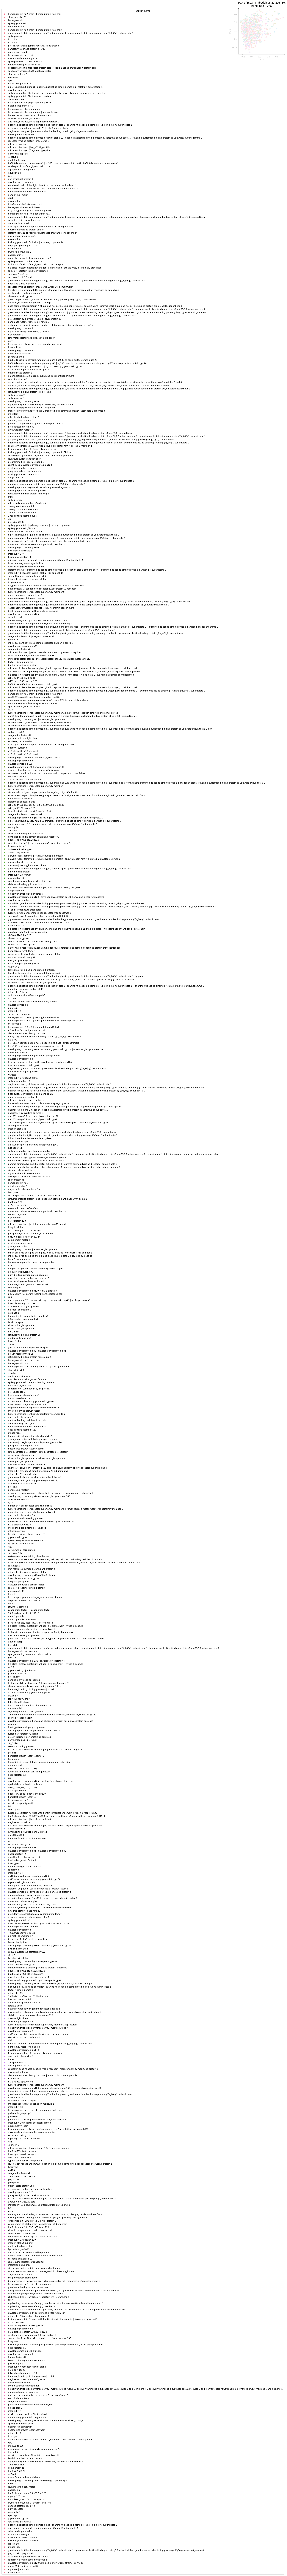

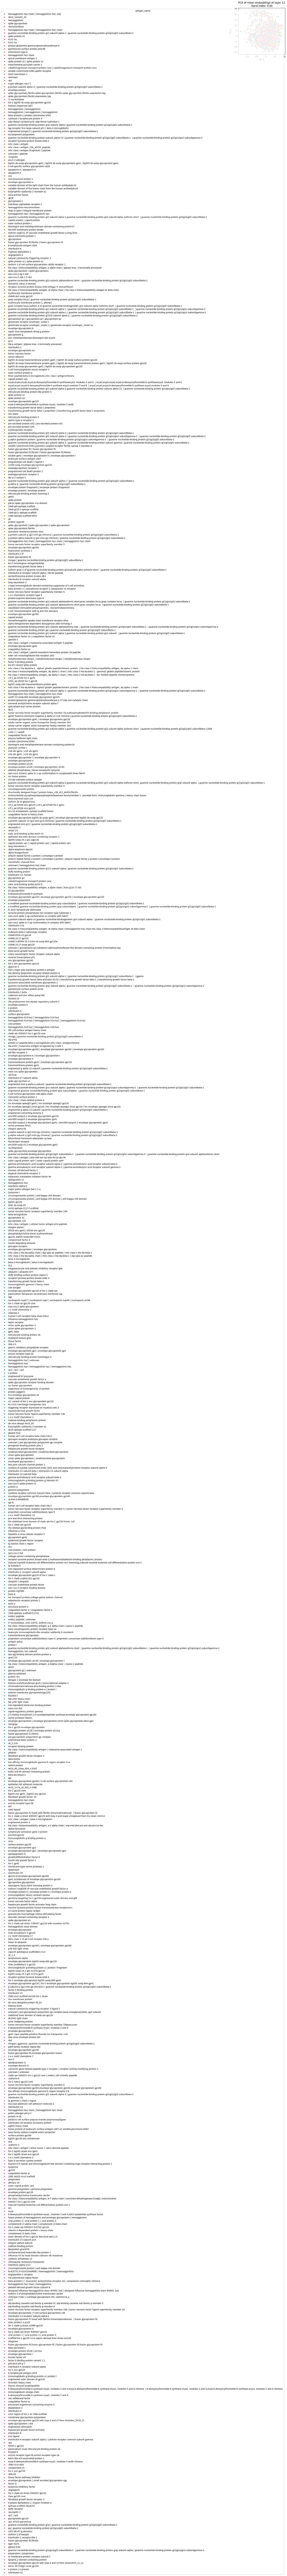

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3
     

def plot_embeddings_at_layer(all_mean_embeddings: torch.Tensor, layer_idx: int):
    stacked_mean_embeddings = torch.stack(
        [embedding[layer_idx, :] for embedding in all_mean_embeddings]
    ).numpy()

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df["antigen_name"], kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df["antigen_name"],
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()
     

plot_embeddings_at_layer(all_mean_embeddings, layer_idx=30)
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=12)
     

In [ ]:
#Quelle für ESMC
@misc{esm2024cambrian,
  author = {{ESM Team}},
  title = {ESM Cambrian: Revealing the mysteries of proteins with unsupervised learning},
  year = {2024},
  publisher = {EvolutionaryScale Website},
  url = {https://evolutionaryscale.ai/blog/esm-cambrian},
  urldate = {2024-12-04}
}